1. Preprocess: Categorical data 숫자형으로 encoding -> missing value 채우기(imputation) (numerical column 에는 mean value를 사용하고, categorical column에는 mode value를 사용합니다.)

2. Model Definiotion: Pycaret의 기본설정

3. Training: Linear Regresssion 사용

4. Evaluation: Stratifeid K-fold CV로 Linear Regression 교차검증 및 성능 상승

5. Hyper Parameter Tuning: pycaret의 Random Grid Search 사용

In [18]:
!python3 -m pip install pandas
!python3 -m pip install 'pycaret[full]'
!python3 -m pip install 'pycaret[tuners]'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', None)
import datetime as dt

In [22]:
start_time=dt.datetime.now()
print("started at",start_time)

started at 2024-07-30 19:53:23.531970


<h2>1. 데이터 로드</h2>

In [24]:
#load and read

data = pd.read_csv('MCHAT.csv')
data = data.drop(['Subject_Id', 'InspectDate','1st_Screening_ASD_Criteria', 'Congenital_Genetic_Disorder',
       'History_of_Brain_Damage', 'Seizure_or_Neurological_disease',
       'SurveyApplicableMonthAge', 'Total_Score'], axis = 1)
# https://github.com/skwgbobf/ASD_Kaggle/blob/main/4.Kaggle1_%20BERT%20Classification.ipynb

# train test 8:2로 나눕니다.
np.random.seed(112)
train, test = np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(train), len(test))


114 29


<h2>2. 모델 생성 + Preprocess</h2>

In [25]:
# 모델에 생성에 사용될 설정
from pycaret.classification import *
reg = setup(data=train,
           target= 'Class/ASD',
           verbose = False, # silent=True
           )

# setup()에서 기본적으로 missing value를 채우고 categorical data를 숫자화 합니다.

<h2>3. Training and Hyper Parameter Tuning </h2>

In [26]:
# 사용 가능한 모든 모델들과 비교
best_model = compare_models()

# 모델 생성: Linear Regression
lr = create_model('lr')

# 하이퍼 파라미터 튜닝 (Random Grid Search 사용)
tuned_lr = tune_model(lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8500,0.9000,0.9000,0.9086,0.8975,0.5957,0.6218,0.0070
lr,Logistic Regression,0.8375,0.9167,0.9167,0.8786,0.8948,0.5314,0.5491,0.0090
catboost,CatBoost Classifier,0.8375,0.9000,0.8667,0.9262,0.8843,0.5810,0.6108,0.1790
nb,Naive Bayes,0.8250,0.8208,0.8333,0.9357,0.8750,0.5743,0.6045,0.0070
rf,Random Forest Classifier,0.8000,0.8833,0.8500,0.8871,0.8647,0.4686,0.4822,0.0190
gbc,Gradient Boosting Classifier,0.8000,0.8208,0.8500,0.8821,0.8610,0.4829,0.4927,0.0090
xgboost,Extreme Gradient Boosting,0.7982,0.8917,0.9000,0.8500,0.8716,0.3969,0.4058,0.0070
et,Extra Trees Classifier,0.7875,0.8208,0.8500,0.8679,0.8534,0.4429,0.4582,0.0170
dt,Decision Tree Classifier,0.7750,0.7250,0.8333,0.8655,0.8444,0.4162,0.4260,0.0070
ada,Ada Boost Classifier,0.7750,0.8500,0.8500,0.8562,0.8476,0.3976,0.4151,0.0090


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.8750,1.0000,1.0000,0.8571,0.9231,0.6000,0.6547
2,0.6250,0.8333,0.8333,0.7143,0.7692,-0.2000,-0.2182
3,0.8750,0.9167,1.0000,0.8571,0.9231,0.6000,0.6547
4,0.8750,1.0000,1.0000,0.8571,0.9231,0.6000,0.6547
5,0.7500,0.7500,0.8333,0.8333,0.8333,0.3333,0.3333
6,0.7500,0.8333,0.8333,0.8333,0.8333,0.3333,0.3333
7,0.7500,0.8333,0.8333,0.8333,0.8333,0.3333,0.3333
8,0.8750,1.0000,0.8333,1.0000,0.9091,0.7143,0.7454


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.8750,1.0000,1.0000,0.8571,0.9231,0.6000,0.6547
2,0.6250,0.8333,0.8333,0.7143,0.7692,-0.2000,-0.2182
3,0.8750,0.9167,1.0000,0.8571,0.9231,0.6000,0.6547
4,0.8750,0.9167,1.0000,0.8571,0.9231,0.6000,0.6547
5,0.7500,0.7500,0.8333,0.8333,0.8333,0.3333,0.3333
6,0.8750,0.8333,0.8333,1.0000,0.9091,0.7143,0.7454
7,0.8750,0.8333,0.8333,1.0000,0.9091,0.7143,0.7454
8,0.8750,1.0000,0.8333,1.0000,0.9091,0.7143,0.7454


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


<h2>4. Interpretation </h2>

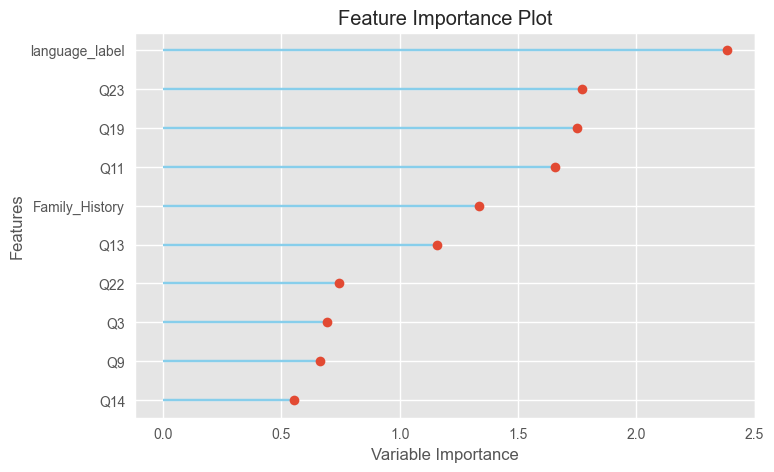

In [27]:
plot_model(tuned_lr, plot='feature')

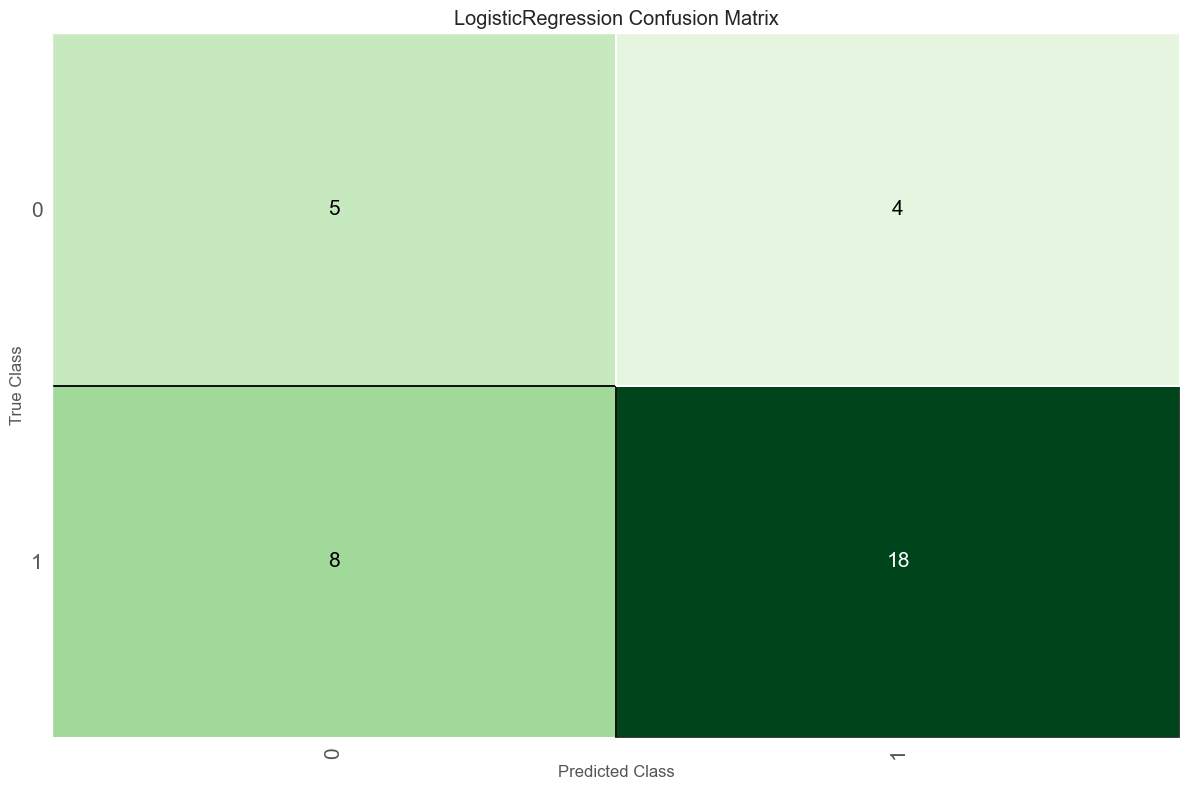

In [28]:
plot_model(tuned_lr, plot = 'confusion_matrix')

In [29]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
predict_model(tuned_lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6571,0.7500,0.6923,0.8182,0.7500,0.2164,0.2242


In [31]:
# finalize rf model
final_lr = finalize_model(tuned_lr)

# print final model parameters
print(final_lr)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Family_History', 'Age', 'Q1',
                                             'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7',
                                             'Q8', 'Q9', 'Q10', 'Q11', 'Q12',
                                             'Q13', 'Q14', 'Q15', 'Q16', 'Q17',
                                             'Q18', 'Q19', 'Q20', 'Q21', 'Q22',
                                             'Q23', 'language_label'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              k...
                 TransformerWrapper(exclude=None, include=None,
                                    trans

<h2>5. Prediction</h2>

In [32]:
predictions1 = predict_model(tuned_lr, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7241,0.8043,0.9130,0.7778,0.8400,-0.1154,-0.1390


In [33]:
# 학습된 모델로 테스트 셋 예측 결과

# Calculate the number of matches
assert len(test['Class/ASD']) == len(predictions1)

matches = test['Class/ASD'] == predictions1['prediction_label']

num_matches = matches.sum()

# Calculate the matching percentage
matching_percentage = (num_matches / len(predictions1)) * 100

print(f"Accuracy: {matching_percentage:.2f}%")
print(f"Mean AUC: 0.9083 - 5. Prediction 결과에서 확인 가능")

Accuracy: 72.41%
Mean AUC: 0.6000 - 5. Prediction 결과에서 확인 가능
